# Import Package

In [1]:
import numpy as np
import pandas as pd 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle

In [2]:
print(f'''
{np.__version__},
{pd.__version__},
{tf.__version__}''')


1.21.6,
1.3.5,
2.8.2


In [3]:
!python --version

Python 3.7.13


# Import Dataset

In [4]:
rating = pd.read_csv('/content/hotel_rating.csv')
hotel = pd.read_csv('/content/Dataset_hotel_Bali.csv')
user = pd.read_csv('/content/user.csv')

In [5]:
# melihat ukuran data
print(f'rating : {rating.shape}')
print(f'hotel : {hotel.shape}')
print(f'user : {user.shape}')

rating : (10000, 3)
hotel : (50, 12)
user : (300, 3)


# Persiapan Dataset

In [6]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,42,3
1,1,22,2
2,1,1,5
3,1,15,3
4,1,40,4


In [7]:
df = rating.copy()

In [8]:
#ENCODING
def dict_encoder(col, data=df):
  unique_val = data[col].unique().tolist()
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

In [9]:
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')
df['user'] = df['User_Id'].map(user_to_user_encoded)

In [10]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

In [11]:
# Mendapatkan jumlah user dan hotel
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)
# mengubah nilai rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)
# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Ratings']), max(df['Place_Ratings'])

In [12]:
print(f'Jumlah user : {num_users}')
print(f'Jumlah Hotel : {num_place}')
print(f'Rating minimum : {min_rating}')
print(f'Rating maximum : {max_rating}')

Jumlah user : 300
Jumlah Hotel : 49
Rating minimum : 1.0
Rating maximum : 5.0


In [13]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head()

,User_Id,Place_Id,Place_Ratings,user,place
6252,188,20,3.0,187,27
4684,142,11,2.0,141,37
1731,54,33,3.0,53,47
4742,144,4,3.0,143,40
4521,138,20,5.0,137,27


# Splitting Dataset

In [14]:
# Mambuat Variable x
x = df[['user', 'place']].values
# membuat Variable y
y = df['Place_Ratings'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values

# split dataset
indices = int(0.8*df.shape[0])
x_train, x_test, y_train, y_test = (x[:indices],
                                    x[indices:],
                                    y[:indices],
                                    y[indices:]
                                    )
print(f'x_train : {x_train.shape}')
print(f'x_test : {x_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

x_train : (8000, 2)
x_test : (2000, 2)
y_train : (8000,)
y_test : (2000,)


In [15]:
class Recommended(keras.Model):
  def __init__(self,num_users, num_places, embedding_size, **kwargs):
    super(Recommended, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(num_users,
                                           embedding_size,
                                           embeddings_initializer = 'he_normal',
                                           embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users,1)
    self.places_embedding = layers.Embedding(num_places,
                                             embedding_size,
                                             embeddings_initializer='he_normal',
                                             embeddings_regularizer= keras.regularizers.l2(1e-6)
                                             )
    self.places_bias = layers.Embedding(num_places,1)

  def call(self, inputs):
    user_vec = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:,0])
    places_vec = self.places_embedding(inputs[:,1])
    places_bias = self.places_bias(inputs[:,1])

    dot_user_places = tf.tensordot(user_vec, places_vec, 2)

    x = dot_user_places + user_bias + places_bias

    return tf.nn.sigmoid(x)


In [24]:
model = Recommended(num_users, num_place, 50)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=keras.optimizers.Adam(lr=0.0005),
              metrics=['accuracy']
              )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# training Model

In [25]:
history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 50,
    validation_data = (x_test, y_test)
)

Epoch 1/50
250/250 [==============================] - 2s 4ms/step - loss: 0.7480 - accuracy: 0.1880 - val_loss: 0.7283 - val_accuracy: 0.1905
Epoch 2/50
250/250 [==============================] - 1s 3ms/step - loss: 0.7422 - accuracy: 0.1916 - val_loss: 0.7255 - val_accuracy: 0.1855
Epoch 3/50
250/250 [==============================] - 1s 2ms/step - loss: 0.7280 - accuracy: 0.1904 - val_loss: 0.7238 - val_accuracy: 0.1860
Epoch 4/50
250/250 [==============================] - 1s 3ms/step - loss: 0.7285 - accuracy: 0.1893 - val_loss: 0.7228 - val_accuracy: 0.1835
Epoch 5/50
250/250 [==============================] - 1s 2ms/step - loss: 0.7243 - accuracy: 0.1894 - val_loss: 0.7214 - val_accuracy: 0.1870
Epoch 6/50
250/250 [==============================] - 1s 2ms/step - loss: 0.7223 - accuracy: 0.1912 - val_loss: 0.7195 - val_accuracy: 0.1860
Epoch 7/50
250/250 [==============================] - 1s 3ms/step - loss: 0.7174 - accuracy: 0.1996 - val_loss: 0.7181 - val_accuracy: 0.1905
Epoch 

# Evaluasi Model

In [26]:
model.evaluate(x=x_test, y=y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.7065 - accuracy: 0.2060


[0.7065238356590271, 0.20600000023841858]

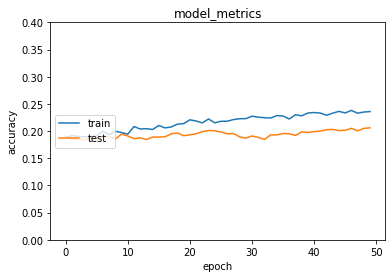

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_metrics')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.4)
plt.legend(['train', 'test'], loc='center left')
plt.show()

# Penerapan Model

In [28]:
hotel.columns

Index(['Unnamed: 0', 'Id', 'Name', 'Stars', 'Ratings', 'Price', 'Addres',
       'Coordinate', 'Description', 'Lat', 'Long', 'Images'],
      dtype='object')

In [30]:
place_df = hotel[['Id', 'Name', 'Stars', 'Ratings', 'Price', 'Addres', 'Coordinate',
       'Description', 'Lat', 'Long']]
place_df.columns = ['Id', 'Name', 'Stars', 'Ratings', 'Price', 'Addres', 'Coordinate',
       'Description', 'Lat', 'Long']
df = rating.copy()

In [29]:
# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

In [31]:
# Membuat data lokasi yang belum dikunjungi user
place_not_visited = place_df[~place_df['Id'].isin(place_visited_by_user.Place_Id.values)]['Id'] 
place_not_visited = list(
    set(place_not_visited).intersection(set(place_to_place_encoded.keys()))
)
 
place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

In [32]:
# Mengambil top 5 recommendation
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-5:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]
 

print('')
print('----' * 15)
print('Top 5 place recommendation')
print('----' * 15)
 
recommended_place = place_df[place_df['Id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.Name, '\n    ', row.Addres, ',', 'Harga Tiket Masuk ', row.Price, ',', 'Rating Wisata ', row.Ratings,'\n')

print('==='*15)


------------------------------------------------------------
Top 5 place recommendation
------------------------------------------------------------
1 . Quest San Hotel Denpasar by ASTON 
     Jl. Mahendradatta No.93, Padangsambian, Kec. Denpasar Bar., Kota Denpasar, Bali 80117 , Harga Tiket Masuk  243,832.00 , Rating Wisata  4.4 

2 . Hadi Poetra Hotel 
     Jl. Raya Kuta No.323-378, Kuta, Kec. Kuta, Kabupaten Badung, Bali 80361 , Harga Tiket Masuk  187,789.00 , Rating Wisata  4.2 

3 . Paditeras Boutique Hotel Seminyak 
     Jl. Lb. Sari No.19, Seminyak, Kec. Kuta Utara, Kabupaten Badung, Bali 80361 , Harga Tiket Masuk  Nan , Rating Wisata  4.3 

4 . J Hotel Kuta 
     Jalan Raya Kuta No.88D, Kuta, Kec. Kuta, Kabupaten Badung, Bali 80361 , Harga Tiket Masuk  170,668.00 , Rating Wisata  4.2 

5 . Golden Tulip Essential Denpasar 
     Jl. Gatot Subroto Barat No.101, Padangsambian Kaja, Kec. Denpasar Bar., Kota Denpasar, Bali 80118 , Harga Tiket Masuk  181,425.00 , Rating Wisata  4.2 


# Save Model

In [ ]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model.
# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpiqpaze92/assets


In [33]:
filename = 'hotel_bali_model.pkl'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://c981e122-cc10-4dfe-9481-e8b008bb3fed/assets


In [34]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.evaluate(x=x_test, y=y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.7065 - accuracy: 0.2060
